In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import seaborn as sns

In [ ]:
sns.set(style="darkgrid")
plt.style.use('dark_background')

In [ ]:
data = pd.read_csv('electricityConsumptionAndProductioction.csv')
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

data = data[['Consumption']]

data['Consumption'], fitted_lambda = boxcox(data['Consumption'])

new_data = data[['Consumption']].copy()


<ipython-input-8-ba8d28827bd4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Consumption'], fitted_lambda = boxcox(data['Consumption'])


In [ ]:
# Lagged Features
for i in range(1, 13):
    new_data[f'lag_{i}'] = new_data['Consumption'].shift(i)

# Rolling Statistics
new_data['rolling_mean_7'] = new_data['Consumption'].rolling(window=7).mean()
new_data['rolling_std_7'] = new_data['Consumption'].rolling(window=7).std()

# Seasonal Decomposition
result = seasonal_decompose(new_data['Consumption'], model='additive', period=365)
new_data['trend'] = result.trend
new_data['seasonal'] = result.seasonal
new_data['residual'] = result.resid

# Fourier Terms
day_of_year = new_data.index.dayofyear
new_data['sin_365'] = np.sin(2 * np.pi * day_of_year / 365)
new_data['cos_365'] = np.cos(2 * np.pi * day_of_year / 365)

# DateTime Features
new_data['DateTime'] = new_data.index
new_data['hour'] = new_data['DateTime'].dt.hour
new_data['dayofweek'] = new_data['DateTime'].dt.dayofweek
new_data['quarter'] = new_data['DateTime'].dt.quarter
new_data['month'] = new_data['DateTime'].dt.month
new_data['year'] = new_data['DateTime'].dt.year
new_data['dayofyear'] = new_data['DateTime'].dt.dayofyear
new_data['dayofmonth'] = new_data['DateTime'].dt.day
new_data['weekofyear'] = new_data['DateTime'].dt.isocalendar().week

# Differencing
new_data['diff'] = new_data['Consumption'].diff()
for i in range(1, 13):
    new_data[f'diff_lag_{i}'] = new_data['diff'].shift(i)

new_data.dropna(inplace=True)

if 'DateTime' in new_data.columns:
    new_data.drop(columns=['DateTime'], inplace=True)

print(new_data.head())

                     Consumption      lag_1      lag_2      lag_3      lag_4  \
DateTime                                                                       
2019-01-08 14:00:00    72.237510  72.932538  73.023161  73.690926  73.892530   
2019-01-08 15:00:00    72.092828  72.237510  72.932538  73.023161  73.690926   
2019-01-08 16:00:00    72.421504  72.092828  72.237510  72.932538  73.023161   
2019-01-08 17:00:00    73.809629  72.421504  72.092828  72.237510  72.932538   
2019-01-08 18:00:00    73.936877  73.809629  72.421504  72.092828  72.237510   

                         lag_5      lag_6      lag_7      lag_8      lag_9  \
DateTime                                                                     
2019-01-08 14:00:00  74.019538  73.140688  70.863394  68.090638  66.342105   
2019-01-08 15:00:00  73.892530  74.019538  73.140688  70.863394  68.090638   
2019-01-08 16:00:00  73.690926  73.892530  74.019538  73.140688  70.863394   
2019-01-08 17:00:00  73.023161  73.690926  73.892

vif_pca_1 Analysis:
   feature           VIF
0    lag_1   9152.578014
1    lag_2  39797.400885
2    lag_3  49162.348346
3    lag_4  49285.266956
4    lag_5  49314.152518
5    lag_6  49278.055307
6    lag_7  49278.434996
7    lag_8  49314.861454
8    lag_9  49287.057884
9   lag_10  49164.815105
10  lag_11  39799.012748
11  lag_12   9152.728106


<ipython-input-10-d1dd7e6284d7>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'PC{i+1}' for i in range(len(explained_variance))], y=explained_variance, palette="Blues_r")


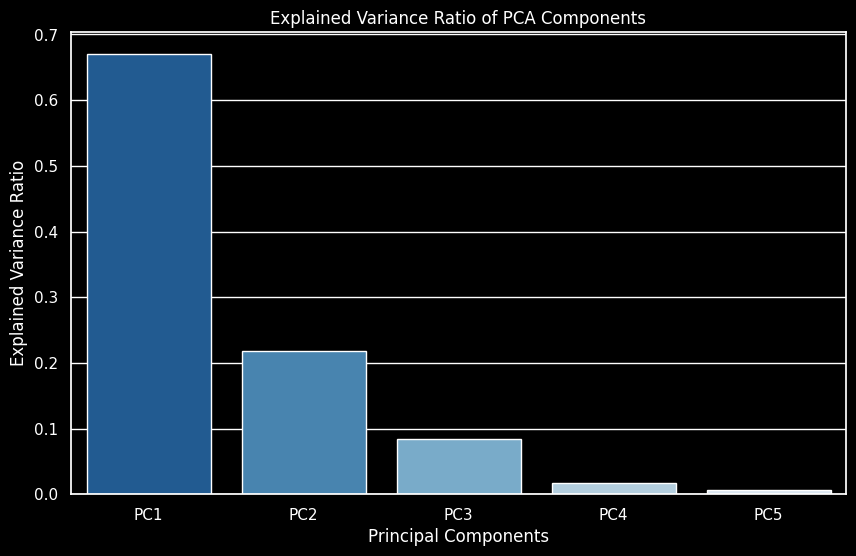

In [ ]:
def calculate_vif_and_pca(data):
    X = data[[f'lag_{i}' for i in range(1, 13)]]

    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X, data['Consumption'])

    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    print(vif_data)

    pca = PCA(n_components=5)
    pca_features = pca.fit_transform(X)
    pca_df = pd.DataFrame(pca_features, index=data.index, columns=[f'pca_{i}' for i in range(1, 6)])
    data = pd.concat([data, pca_df], axis=1)

    plt.figure(figsize=(10, 6))
    explained_variance = pca.explained_variance_ratio_
    sns.barplot(x=[f'PC{i+1}' for i in range(len(explained_variance))], y=explained_variance, palette="Blues_r")
    plt.title('Explained Variance Ratio of PCA Components')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

    return data

print("vif_pca_1 Analysis:")
vif_pca_1 = calculate_vif_and_pca(new_data)

In [ ]:
columns_to_drop = [col for col in new_data.columns if 'lag' in col]
new_data.drop(columns=columns_to_drop, inplace=True)

print(new_data.head())

                     Consumption  rolling_mean_7  rolling_std_7      trend  \
DateTime                                                                     
2019-01-08 14:00:00    72.237510       73.276699       0.630315  67.960868   
2019-01-08 15:00:00    72.092828       73.127004       0.775669  67.967673   
2019-01-08 16:00:00    72.421504       72.898714       0.700746  67.983570   
2019-01-08 17:00:00    73.809629       72.886871       0.681590  68.009685   
2019-01-08 18:00:00    73.936877       72.922007       0.734252  68.041054   

                     seasonal  residual   sin_365   cos_365  hour  dayofweek  \
DateTime                                                                       
2019-01-08 14:00:00  0.147308  4.129334  0.137279  0.990532    14          1   
2019-01-08 15:00:00  0.111360  4.013796  0.137279  0.990532    15          1   
2019-01-08 16:00:00  0.047641  4.390293  0.137279  0.990532    16          1   
2019-01-08 17:00:00  0.059974  5.739969  0.137279  0.

vif_pca_2 Analysis:
           feature            VIF
0   rolling_mean_7    3341.346214
1    rolling_std_7       6.609657
2            trend    4869.281491
3         seasonal       1.023624
4         residual       6.111259
5          sin_365       3.702300
6          cos_365       2.112702
7             hour      10.690287
8        dayofweek       3.942919
9          quarter     117.780639
10           month  161248.151458
11            year    4478.813061
12       dayofyear  142933.473418
13      dayofmonth    1078.444748
14      weekofyear      82.808781
15            diff       3.394563


<ipython-input-12-f3265c27ce45>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'PC{i+1}' for i in range(len(explained_variance))], y=explained_variance, palette="Blues_r")


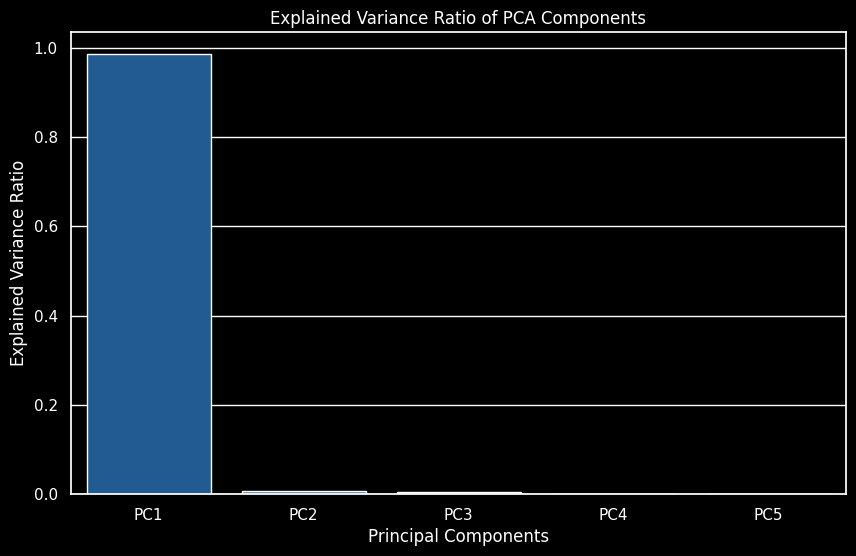

In [ ]:
def calculate_vif_and_pca(data):
    X = data.drop(columns=['Consumption']).astype(float)

    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    print(vif_data)

    pca = PCA(n_components=5)
    pca_features = pca.fit_transform(X)
    pca_df = pd.DataFrame(pca_features, index=data.index, columns=[f'pca_{i}' for i in range(1, 6)])
    data = pd.concat([data, pca_df], axis=1)

    plt.figure(figsize=(10, 6))
    explained_variance = pca.explained_variance_ratio_
    sns.barplot(x=[f'PC{i+1}' for i in range(len(explained_variance))], y=explained_variance, palette="Blues_r")
    plt.title('Explained Variance Ratio of PCA Components')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

    return data

print("vif_pca_2 Analysis:")
vif_pca_2 = calculate_vif_and_pca(new_data)

In [ ]:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

X = new_data.drop(columns=['Consumption']).astype(float)

vif_data = calculate_vif(X)

filtered_features = vif_data[vif_data['VIF'] < 5]['feature']
filtered_data = new_data[['Consumption'] + filtered_features.tolist()]

print("Filtered features with VIF < 5:")
print(filtered_features)

Filtered features with VIF < 5:
3      seasonal
5       sin_365
6       cos_365
8     dayofweek
15         diff
Name: feature, dtype: object


In [ ]:
def split_train_test_by_date(data, split_date='2023-03-01'):
    train_data = data.loc[:split_date]
    test_data = data.loc[split_date:]
    return train_data, test_data

def train_and_evaluate_rf(train_data, test_data, target='Consumption'):
    X_train = train_data[['seasonal', 'diff', 'sin_365', 'cos_365', 'dayofweek']]
    y_train = train_data[target]
    X_test = test_data[['seasonal', 'diff', 'sin_365', 'cos_365', 'dayofweek']]
    y_test = test_data[target]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    y_train_pred_orig = inv_boxcox(y_train_pred, fitted_lambda)
    y_test_pred_orig = inv_boxcox(y_test_pred, fitted_lambda)
    y_train_orig = inv_boxcox(y_train, fitted_lambda)
    y_test_orig = inv_boxcox(y_test, fitted_lambda)

    train_mse = mean_squared_error(y_train_orig, y_train_pred_orig)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train_orig, y_train_pred_orig)

    test_mse = mean_squared_error(y_test_orig, y_test_pred_orig)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test_orig, y_test_pred_orig)

    print(f"Train Mean Squared Error: {train_mse}")
    print(f"Train Root Mean Squared Error: {train_rmse}")
    print(f"Train R^2 Score: {train_r2}")
    print(f"Test Mean Squared Error: {test_mse}")
    print(f"Test Root Mean Squared Error: {test_rmse}")
    print(f"Test R^2 Score: {test_r2}")

    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, y_test_orig, label='Actual', color='b')
    plt.plot(test_data.index, y_test_pred_orig, label='Predicted', color='r')
    plt.title('Actual vs Predicted Consumption (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Consumption')
    plt.legend()
    plt.show()

    return rf

Prediction Analysis:
Train Mean Squared Error: 68873.15722627664
Train Root Mean Squared Error: 262.4369585753437
Train R^2 Score: 0.9357565086279329
Test Mean Squared Error: 659159.5765824252
Test Root Mean Squared Error: 811.8864308401916
Test R^2 Score: 0.24308714821131783


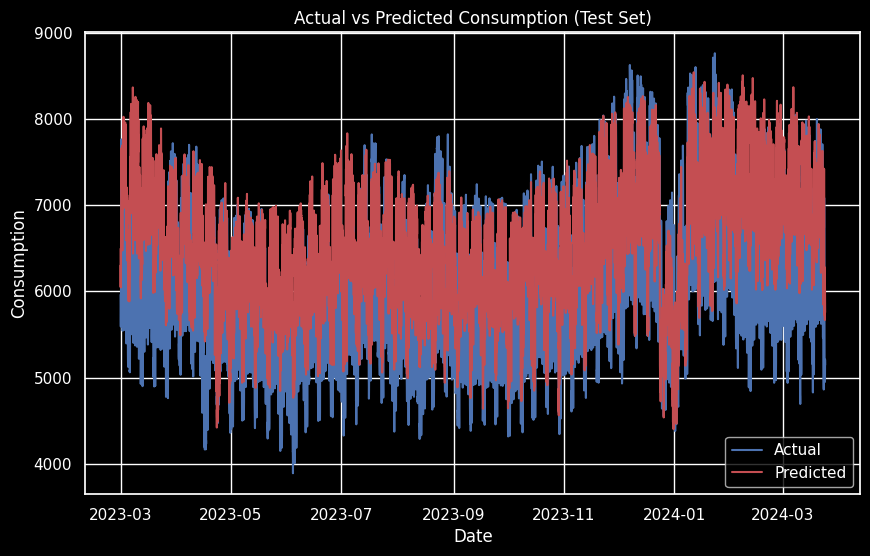

In [ ]:
train_data, test_data = split_train_test_by_date(filtered_data, split_date='2023-03-01')

print("Prediction Analysis:")
rf_model = train_and_evaluate_rf(train_data, test_data)

In [ ]:
## Hyperparameter Tuned Version
# def train_and_evaluate_rf(train_data, test_data, target='Consumption'):
#     X_train = train_data[['seasonal', 'diff', 'sin_365', 'cos_365', 'dayofweek']]
#     y_train = train_data[target]
#     X_test = test_data[['seasonal', 'diff', 'sin_365', 'cos_365', 'dayofweek']]
#     y_test = test_data[target]

#     param_grid = {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [10, 20, 30, None],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4],
#         'bootstrap': [True, False]
#     }

#     rf = RandomForestRegressor(random_state=42)
#     grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
#     grid_search.fit(X_train, y_train)

#     print(f"Best Parameters: {grid_search.best_params_}")

#     best_rf = grid_search.best_estimator_

#     y_train_pred = best_rf.predict(X_train)
#     y_test_pred = best_rf.predict(X_test)

#     train_mse = mean_squared_error(y_train, y_train_pred)
#     train_rmse = np.sqrt(train_mse)
#     train_r2 = r2_score(y_train, y_train_pred)

#     test_mse = mean_squared_error(y_test, y_test_pred)
#     test_rmse = np.sqrt(test_mse)
#     test_r2 = r2_score(y_test, y_test_pred)

#     print(f"Train Mean Squared Error: {train_mse}")
#     print(f"Train Root Mean Squared Error: {train_rmse}")
#     print(f"Train R^2 Score: {train_r2}")
#     print(f"Test Mean Squared Error: {test_mse}")
#     print(f"Test Root Mean Squared Error: {test_rmse}")
#     print(f"Test R^2 Score: {test_r2}")

#     plt.figure(figsize=(10, 6))
#     plt.plot(test_data.index, y_test, label='Actual', color='b')
#     plt.plot(test_data.index, y_test_pred, label='Predicted', color='r')
#     plt.title('Actual vs Predicted Consumption (Test Set)')
#     plt.xlabel('Date')
#     plt.ylabel('Consumption')
#     plt.legend()
#     plt.show()

#     return best_rf

In [ ]:
## Hyperparameter Tuned Version
# split_date = '2020-03-01'
# pre_covid_data = filtered_data.loc[:split_date]
# post_covid_data = filtered_data.loc[split_date:]

# pre_covid_train, pre_covid_test = split_train_test(pre_covid_data)
# post_covid_train, post_covid_test = split_train_test(post_covid_data)

# print("Pre-COVID Analysis:")
# pre_covid_rf = train_and_evaluate_rf(pre_covid_train, pre_covid_test)

# print("Post-COVID Analysis:")
# post_covid_rf = train_and_evaluate_rf(post_covid_train, post_covid_test)

Pre-COVID Analysis:
Fitting 3 folds for each of 216 candidates, totalling 648 fits


KeyboardInterrupt: 

In [ ]:
forecast_start = test_data.index[0]
forecast_end = test_data.index[-1]
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='H')

forecast_df = pd.DataFrame(index=forecast_dates, columns=['seasonal', 'diff', 'sin_365', 'cos_365', 'dayofweek'])
forecast_df['Consumption'] = np.nan

last_known_values = train_data.iloc[-1][['seasonal', 'diff', 'sin_365', 'cos_365', 'dayofweek']]

In [ ]:
for date in forecast_dates:
    features = last_known_values.copy()
    features['dayofweek'] = date.dayofweek
    features['sin_365'] = np.sin(2 * np.pi * date.timetuple().tm_yday / 365)
    features['cos_365'] = np.cos(2 * np.pi * date.timetuple().tm_yday / 365)

    consumption_pred = rf_model.predict([features])[0]

    consumption_pred_orig = inv_boxcox(consumption_pred, fitted_lambda)

    forecast_df.loc[date, 'Consumption'] = consumption_pred_orig

    last_known_values = features

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dis

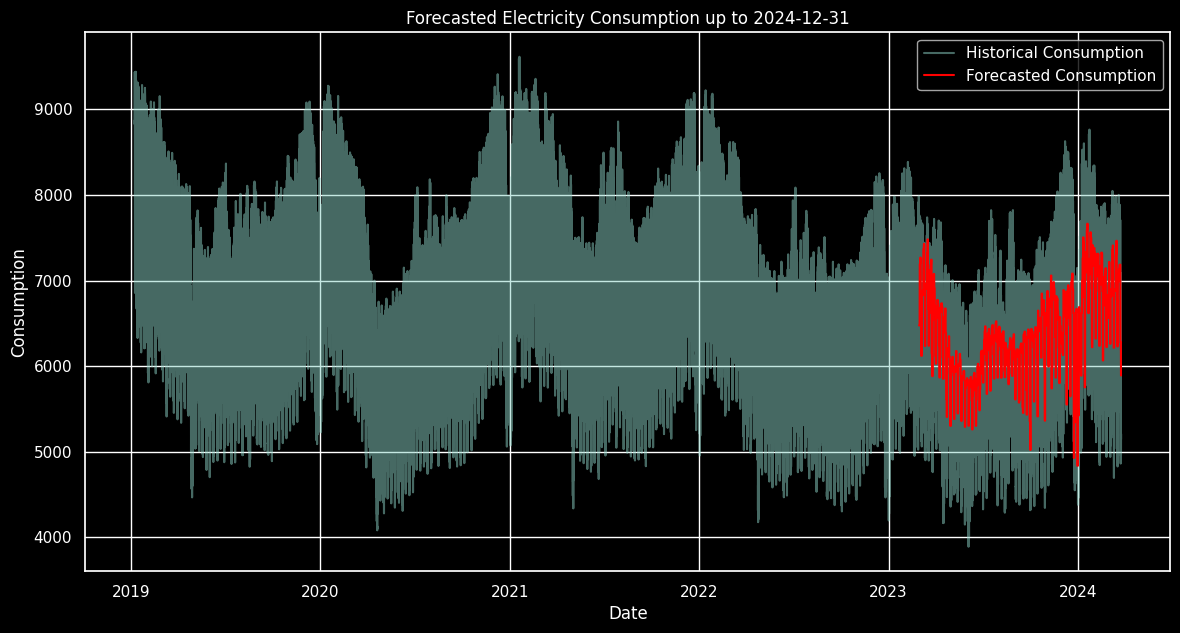

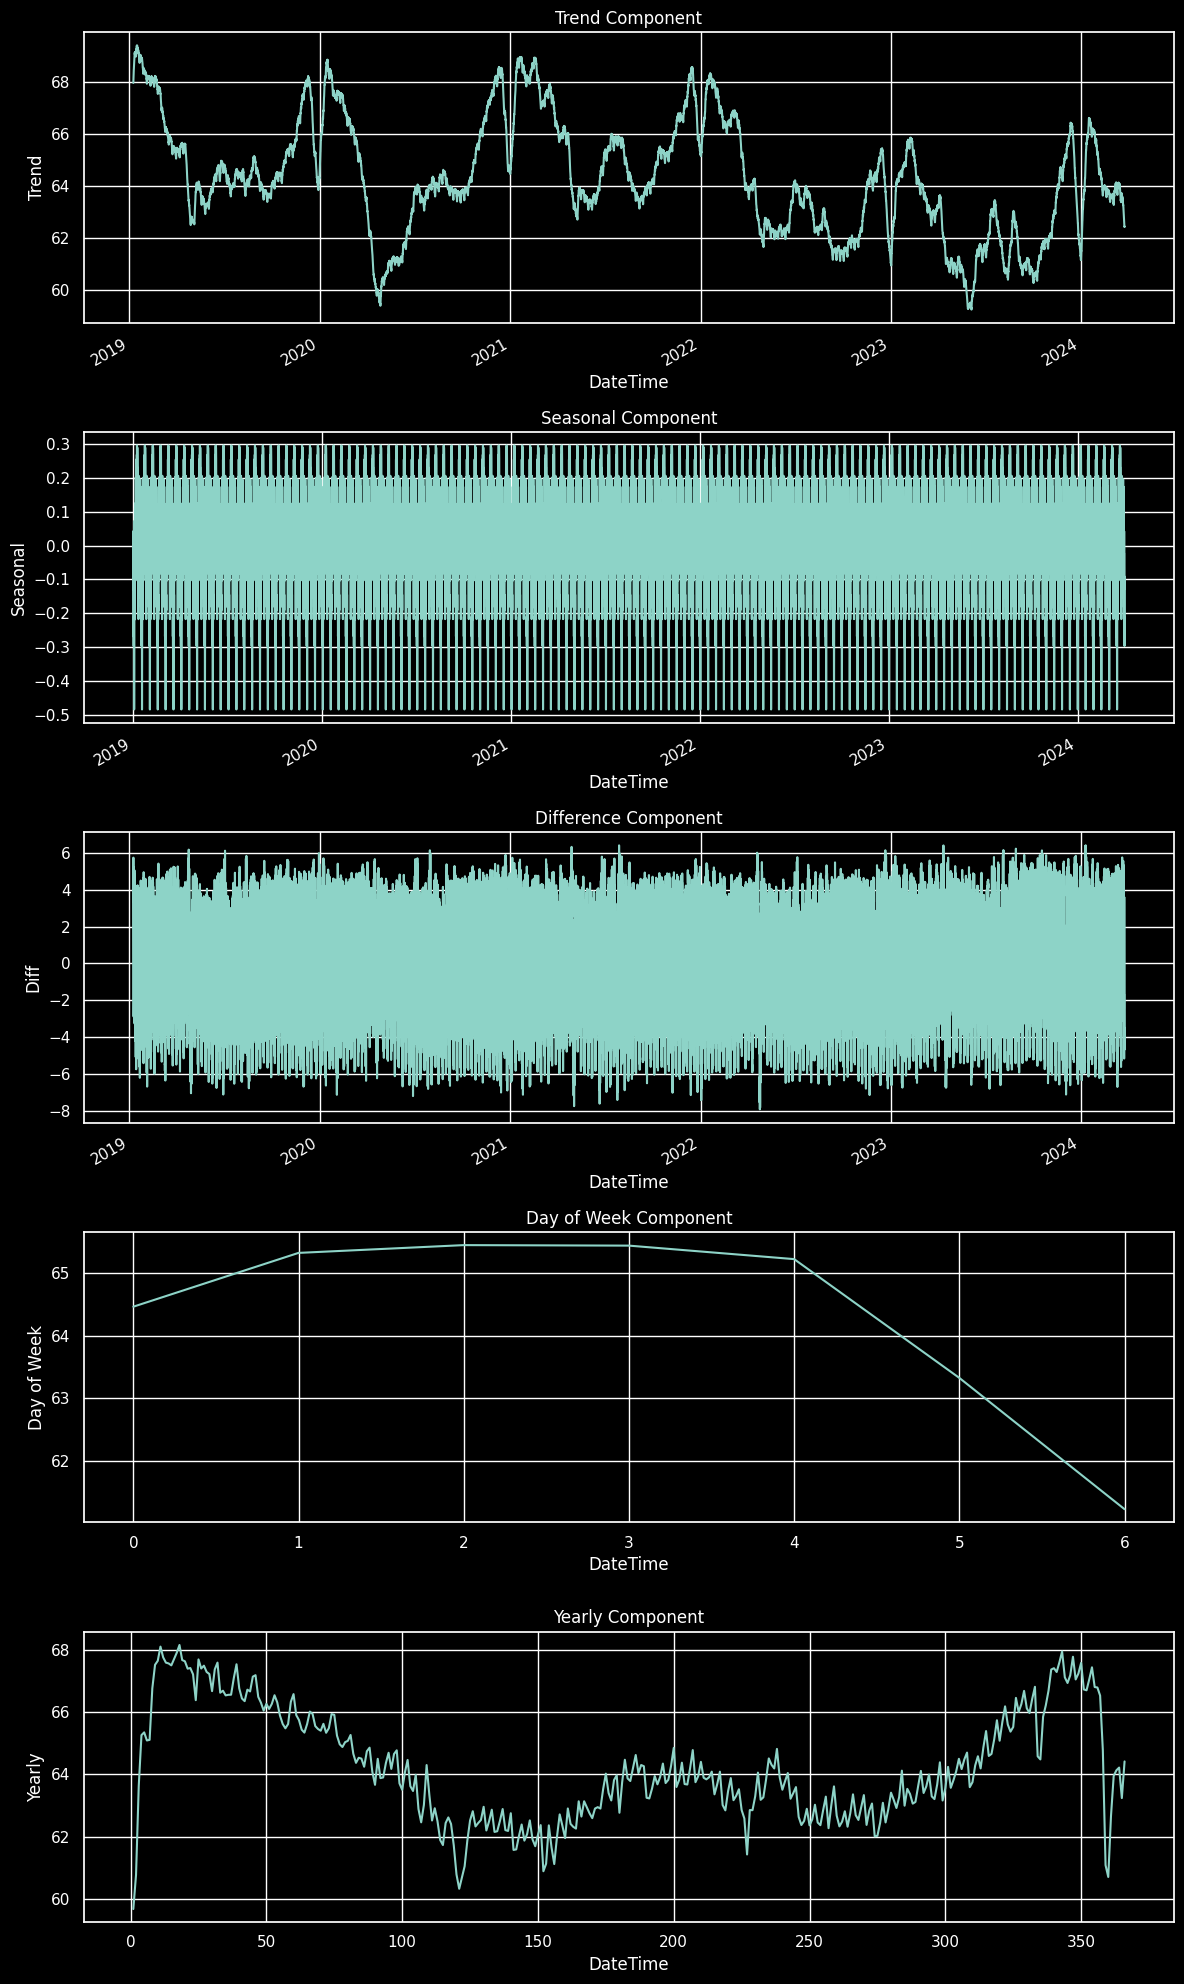

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(filtered_data.index, inv_boxcox(filtered_data['Consumption'], fitted_lambda), label='Historical Consumption', alpha=0.5)
plt.plot(forecast_df.index, forecast_df['Consumption'], label='Forecasted Consumption', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Forecasted Electricity Consumption up to 2024-12-31')
plt.legend()
plt.show()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(12, 20))

result.trend.plot(ax=ax1)
ax1.set_ylabel('Trend')
ax1.set_title('Trend Component')

result.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
ax2.set_title('Seasonal Component')

result.resid.plot(ax=ax3)
ax3.set_ylabel('Diff')
ax3.set_title('Difference Component')

new_data.groupby(new_data.index.dayofweek)['Consumption'].mean().plot(ax=ax4)
ax4.set_ylabel('Day of Week')
ax4.set_title('Day of Week Component')

new_data.groupby(new_data.index.dayofyear)['Consumption'].mean().plot(ax=ax5)
ax5.set_ylabel('Yearly')
ax5.set_title('Yearly Component')

plt.tight_layout()
plt.show()
